In [448]:
from lxml import etree
from re import sub
import xml.etree.ElementTree as ET
import string
import os
from glob import glob
from tqdm import tqdm
import numpy as np

sigles = [os.path.basename(fn).replace('xml_', '').replace('.xml', '') for fn in glob( '../../data/xml_martijn/*.xml')] #maak een lijst van sigles, doe dat door de basisnaam van een specifiek path te nemen (fn) en daarin .txt te vervangen, for... in ... = loop
sigles = sorted(sigles)
sigles
print(sigles)
#sigles = 'A','Ant','B', 'BR', 'C','D', 'D2','E', 'F', 'G', 'Ge', 'K', 'L', 'O', 'W', 'Y', 'Z'

['A', 'Ant', 'B', 'BR', 'C', 'D', 'D2', 'E', 'F', 'G', 'Ge', 'K', 'L', 'O', 'W', 'Y', 'Z']


In [449]:
list(glob('../../data/xml_martijn/*.xml'))

['../../data/xml_martijn/xml_Ge.xml',
 '../../data/xml_martijn/xml_G.xml',
 '../../data/xml_martijn/xml_F.xml',
 '../../data/xml_martijn/xml_D.xml',
 '../../data/xml_martijn/xml_E.xml',
 '../../data/xml_martijn/xml_A.xml',
 '../../data/xml_martijn/xml_W.xml',
 '../../data/xml_martijn/xml_B.xml',
 '../../data/xml_martijn/xml_C.xml',
 '../../data/xml_martijn/xml_Y.xml',
 '../../data/xml_martijn/xml_O.xml',
 '../../data/xml_martijn/xml_Z.xml',
 '../../data/xml_martijn/xml_L.xml',
 '../../data/xml_martijn/xml_BR.xml',
 '../../data/xml_martijn/xml_K.xml',
 '../../data/xml_martijn/xml_Ant.xml',
 '../../data/xml_martijn/xml_D2.xml']

In [450]:
def get_gap_lines(tree):
    gap_lines = []
    for text in tree.iterfind('.//' + "{" + NSMAP["MVN"] + "}" + 'text'):
        if 'n' in text.attrib:
            for line in text.iterfind('.//' + "{" + NSMAP["MVN"] + "}" + 'l'):
                if line.find('.//' + "{" + NSMAP["MVN"] + "}" + 'gap') is not None:
                    if 'n' in line.attrib:
                        n_value = line.attrib['n']
                        parts = n_value.split('_')
                        if len(parts) > 1:
                            k = "_".join(parts[1:])  # Join the parts after the first underscore
                        else:
                            k = n_value
                        gap_lines.append(k)
                if line.find('.//' + "{" + NSMAP["MVN"] + "}" + 'uncleaar') is not None:
                     if 'n' in line.attrib:
                        n_value = line.attrib['n']
                        parts = n_value.split('_')
                        if len(parts) > 1:
                            k = "_".join(parts[1:])  # Join the parts after the first underscore
                        else:
                            k = n_value
                        gap_lines.append(k)

    return gap_lines

In [451]:
def get_notes(tree):
    notes = []
    for text in tree.iterfind('.//' + "{" + NSMAP["MVN"] + "}" + 'text'):
        if 'n' in text.attrib:
            for note in text.iterfind('.//' + "{" + NSMAP["MVN"] + "}" + 'note'):
                if 'n' in note.attrib:
                    n_value = note.attrib['n']
                    parts = n_value.split('_')
                    if len(parts) > 1:
                        k = "_".join(parts[1:])  # Join the parts after the first underscore
                    else:
                        k = n_value
                    notes.append(k)
    print(notes)
    return notes

In [452]:
NSMAP = {'MVN': 'http://www.tei-c.org/ns/1.0'} #namespace = collectie van 'symbolic names'
removes = ('teiHeader', 'fw', 'supplied', 'abbr') #fw = forme work = headers, footers,...supplied = tekst toegevoegd door de transcriber 
removes_expan_false = ('teiHeader', 'fw', 'supplied', 'ex', 'expan')
chars = {'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l','m', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'}       

In [453]:
import re
def extract_lines(xml_file, expan = True, #def = fuctie maken die alleen wordt uitgevoerd als je die oproept, extract_lines = de naam van de functie, xml_file = argument in de functie, na de functienaam in ()
                  punct = True, lower = True,
                  sep_abbr = True): 
    
    lines = {}
    gap_lines = [] 
    tree = etree.parse(xml_file) #ElementTree represents the whole XML document as a tree, and Element represents a single node
    
    
    if expan:
        #delete all elements with the provided tag names from a tree or subtree
        #will also remove the tail text unless explicitly set the with_tail keyword argument option to False
        etree.strip_elements(tree, ("{"+ NSMAP["MVN"]+ "}" + s for s in removes), with_tail=False) 
    else: 
        etree.strip_elements(tree, ("{"+ NSMAP["MVN"]+ "}" + s for s in removes_expan_false), with_tail=False)
  
    context = etree.iterwalk(tree, events=("start", "end")) #a tree walker generates events from an existing tree. 'Start' and 'end' represent opening and closing elements
    #u prefix indicates Unicode
    text = u"" #een lege string die tekst heet, u staat voor Unicode 
    #this will be the key in the dictionary of lines {}
    k = '' 
    
    for action, node in context: #bij elke actie bij een element/knooppunt in het overlopen van het xml bestand
        #remove ns for easier access
        #tag_only bevat de tags op een knooppunt
        #.tag selects all child elements with the given tag. A tag is a string identifying what kind of data this element represents (the element type, in other words).
        #.replace removes ns www.tei...
        
        tag_only = node.tag.replace("{http://www.tei-c.org/ns/1.0}","") 
            
        #node.attrib: XML elements have attributes 
        #attrib is a dictionary containing the element’s attributes. 
        if 'n' in node.attrib and tag_only == 'text': 
            title = node.attrib['n'] #for example Eerste Martijn

        if 'n' in node.attrib and tag_only == "l":
           # k = node.attrib['n']
            n_value = node.attrib['n']
            parts = n_value.split('_')
            if len(parts) > 1:
                k = "_".join(parts[1:])  # Join the parts after the first underscore
            else:
                k = n_value 
  
        # if a new pb (standalone element) is processed:
        if action == 'start' and tag_only == 'text': 
            continue
            
        elif action == 'start' and tag_only == 'lg':
            continue 
            
        # if new lb (standalone) is processed:
        elif action == 'start' and tag_only == 'lb':
            continue

        # list elements which you want to iterate through. this is not really neccessary.
        elif tag_only in ("group","text","MVN","body","cb","p","note"):
            continue

        # for all other elements, distinguish between the start-event of the processing and
        # and the end-event. Attach the tail AFTER the child nodes were processed (= end-event) 
         
        elif action == 'start':
            #comment the following two lines out to not get the element markers
            #f.write(f"[{tag_only}]") 
            #text += f"[{tag_only}]"

            ############################################################################
            ########## filter out special characters, bars,                   ##########
            ########## superscript, or specific tags.                         ##########
            ############################################################################
                    
            
            #if a special glyph is present, encode it accordingly
                
            if tag_only == 'g':
                if sep_abbr: #extra toegevoegd door Mike, maar wij gebruiken nu toch de combining macron onder else want mogelijk door 'grapheme'  
                    if node.attrib['ref'] == '#bar': # ā, ē, ī, ō, ū, n̄ etc.
                        text += u'\u005f' #low line _

                    elif node.attrib['ref'] == '#apomod': # ʼ
                        text += u'\u02bc'

                    elif node.attrib['ref'] == '#usmod': # ꝰ
                        text += u'\ua770' 

                    elif node.attrib['ref'] == '#condes': # ꝯ
                        text += u'\ua76f'

                    elif node.attrib['ref'] == '#para': # ¶
                        text += u'\xb6'

                    elif node.attrib['ref'] == '#etfin': # ꝫ
                        text += u'\ua76b'

                    elif node.attrib['ref'] == '#pbardes': # ꝑ
                        text += '\ua751'

                    elif node.attrib['ref'] == '#pbardes': # ꝕ
                        text += u'\ua755'

                    elif node.attrib['ref'] == '#pflour': # ꝓ
                        text += u'\ua753'

                    else:
                        text += str(node.attrib['ref']) # get the actual ref if there still are any left
                    
                else:
                    if node.attrib['ref'] == '#bar': # ā, ē, ī, ō, ū, n̄ etc.
                        text += u'\u0304'

                    elif node.attrib['ref'] == '#apomod': # ʼ
                        text += u'\u02bc'

                    elif node.attrib['ref'] == '#usmod': # ꝰ
                        text += u'\ua770'

                    elif node.attrib['ref'] == '#condes': # ꝯ
                        text += u'\ua76f'

                    elif node.attrib['ref'] == '#para': # ¶
                        text += u'\xb6'

                    elif node.attrib['ref'] == '#etfin': # ꝫ
                        text += u'\ua76b'

                    elif node.attrib['ref'] == '#pbardes': # ꝑ
                        text += u'\ua751'

                    elif node.attrib['ref'] == '#pbardes': # ꝕ
                        text += u'\ua755'

                    elif node.attrib['ref'] == '#pflour': # ꝓ
                        text += u'\ua753'

                    else:
                        node.attrib['ref']
                        text += str(node.attrib['ref']) # get the actual ref if there still are any left

            # encode superscript letters
            superscript_dict = {'a':'ᵃ', 'b':'ᵇ', 'c':'ᶜ', 'd':'ᵈ', 'e':'ᵉ', 'f':'ᶠ',
                               'g':'ᵍ', 'h':'ʰ', 'i':'ᶦ', 'j':'ʲ', 'k':'ᵏ', 'l':'ˡ', 
                                'm':'ᵐ', 'n':'ⁿ', 'o':'ᵒ', 'p':'ᵖ', 'r':'ʳ', 's':'ˢ', 
                                't':'ᵗ', 'u':'ᵘ', 'v':'ᵛ', 'w':'ʷ', 'x':'ˣ', 'y': 'ʸ', 'z': 'ᶻ'}

            if tag_only == 'hi' and 'rend' in node.attrib and node.attrib['rend'] == 'superscript': #rend(ition) supplies information about the appearance of an element
                if node.text in superscript_dict:
                    text += str(superscript_dict[node.text]).strip()

            # encode punctuation marks
            elif tag_only == 'pc':
                text += str(node.text).strip()

            # encode roman numerals
            elif tag_only == 'num':
                if node.text:
                    text += str('.'+node.text+'.').strip()

            # if there is still a node with text in it
            elif (node.text):
                text += node.text        

        # after the child elements
        elif action == 'end':
            #if there is a tail
            #the tail attribute holds the text between the element’s end tag and the next tag, or None
            if (node.tail and node.tail not in "\t"): #if the tail is not yet in the text 
                #comment the following two lines out to not get the tail marker
                #text += "[tail]"
                #f.write("[tail]")
                #append to text-concatenation
                text += str(node.tail)
                
        if tag_only == 'lb':
            if k:
                text = sub(r'\n', '', text) #when an "r" prefix is present, a character following a backslash is included in the string/all backslashes are left in string. 
                if not punct:
                    text = text.translate(str.maketrans('', '', string.punctuation)) #the value of the keys k is the text 
                if lower: 
                    text = text.lower()
                   
                    #text = text[::-1]
                  
                lines[k] = text #the value of the keys k is the text 
                text = ''    
    #print(lines)
    # catch dangling last line (if applicable):
    if text:
        lines[k] = text
    
    num_orig_lines = len(lines)
    print(num_orig_lines)
    # remove lines with gaps:
    gap_lines = get_gap_lines(tree)
    #lines = {k:v for k, v in lines.items() if k not in gap_lines}
    for gl in gap_lines:
        lines[gl] = '<GAP>'                
    print(f'-> removed {num_orig_lines - len(lines)} lines with gaps')
    notes = get_notes(tree)
    print(notes)
    for note in notes: 
        lines[note] = '<NOTE>'
    
    lines = {k:v for k, v in lines.items() if v.strip()} #if a line with a gap is removed, remove empty key, strip() removes spaces #The items() method returns a key-value pair
    
    return lines
lines = extract_lines(f'../../data/xml_martijn/xml_{sigles[0]}.xml', expan = True, punct = False, lower = True)

1766
-> removed 0 lines with gaps
['M1_1_000', 'M1_9_115', 'M1_11_141', 'M1_51_661', 'M1_59_765', 'M1_75_976', 'M2_26_339', 'M3_19_235', 'M3_19_236', 'M3_19_237', 'M3_19_238', 'M3_19_239', 'M3_19_240', 'M3_19_241', 'M3_19_242', 'M3_19_243', 'M3_19_244', 'M3_19_245', 'M3_19_246', 'M3_19_247', 'M3_20_248', 'M3_20_249', 'M3_20_250', 'M3_20_251', 'M3_20_252', 'M3_20_253', 'M3_20_254', 'M3_20_255', 'M3_20_256', 'M3_20_257', 'M3_20_258', 'M3_20_259', 'M3_20_260', 'M3_21_261', 'M3_21_262', 'M3_21_263', 'M3_21_264', 'M3_21_265', 'M3_21_266', 'M3_21_267', 'M3_21_268', 'M3_21_269', 'M3_21_270', 'M3_21_271', 'M3_21_272', 'M3_21_273', 'M3_22_274', 'M3_22_275', 'M3_22_276', 'M3_22_277', 'M3_22_278', 'M3_22_279', 'M3_22_280', 'M3_22_281', 'M3_22_282', 'M3_22_283', 'M3_22_284', 'M3_22_285', 'M3_22_286', 'M3_39_508']
['M1_1_000', 'M1_9_115', 'M1_11_141', 'M1_51_661', 'M1_59_765', 'M1_75_976', 'M2_26_339', 'M3_19_235', 'M3_19_236', 'M3_19_237', 'M3_19_238', 'M3_19_239', 'M3_19_240', 'M3_19_241', 'M3_19

In [454]:
mss = {} #dictionary maken van manuscripten


for sigle in tqdm(sigles): #for... in = loop, toont progress meter 
    mss[sigle] = extract_lines(f'../../data/xml_martijn/xml_{sigle}.xml',
                               expan = True, punct = False, lower = True,
                               sep_abbr = False) #f string waarin 'sigle' wordt ingevuld
#print(mss['O'])

 53%|███████████████████████▎                    | 9/17 [00:00<00:00, 37.93it/s]

1766
-> removed 0 lines with gaps
['M1_1_000', 'M1_9_115', 'M1_11_141', 'M1_51_661', 'M1_59_765', 'M1_75_976', 'M2_26_339', 'M3_19_235', 'M3_19_236', 'M3_19_237', 'M3_19_238', 'M3_19_239', 'M3_19_240', 'M3_19_241', 'M3_19_242', 'M3_19_243', 'M3_19_244', 'M3_19_245', 'M3_19_246', 'M3_19_247', 'M3_20_248', 'M3_20_249', 'M3_20_250', 'M3_20_251', 'M3_20_252', 'M3_20_253', 'M3_20_254', 'M3_20_255', 'M3_20_256', 'M3_20_257', 'M3_20_258', 'M3_20_259', 'M3_20_260', 'M3_21_261', 'M3_21_262', 'M3_21_263', 'M3_21_264', 'M3_21_265', 'M3_21_266', 'M3_21_267', 'M3_21_268', 'M3_21_269', 'M3_21_270', 'M3_21_271', 'M3_21_272', 'M3_21_273', 'M3_22_274', 'M3_22_275', 'M3_22_276', 'M3_22_277', 'M3_22_278', 'M3_22_279', 'M3_22_280', 'M3_22_281', 'M3_22_282', 'M3_22_283', 'M3_22_284', 'M3_22_285', 'M3_22_286', 'M3_39_508']
['M1_1_000', 'M1_9_115', 'M1_11_141', 'M1_51_661', 'M1_59_765', 'M1_75_976', 'M2_26_339', 'M3_19_235', 'M3_19_236', 'M3_19_237', 'M3_19_238', 'M3_19_239', 'M3_19_240', 'M3_19_241', 'M3_19

100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 38.41it/s]

1769
-> removed 0 lines with gaps
['M1_13_157', 'M1_13_158', 'M1_13_159', 'M1_13_160', 'M1_13_161', 'M1_13_162', 'M1_13_163', 'M1_13_164', 'M1_13_165', 'M1_13_166', 'M1_13_167', 'M1_13_168', 'M1_13_169', 'M1_22_274', 'M1_22_275', 'M1_22_276', 'M1_22_277', 'M1_22_278', 'M1_22_279', 'M1_22_280', 'M1_22_281', 'M1_22_282', 'M1_22_283', 'M1_22_284', 'M1_22_285', 'M1_22_286', 'M1_31_391', 'M1_31_392', 'M1_31_393', 'M1_31_394', 'M1_31_395', 'M1_31_396', 'M1_31_397', 'M1_31_398', 'M1_31_399', 'M1_31_400', 'M1_31_401', 'M1_31_402', 'M1_31_403', 'M1_32_404', 'M1_32_405', 'M1_32_406', 'M1_32_407', 'M1_32_408', 'M1_32_409', 'M1_32_410', 'M1_32_411', 'M1_32_412', 'M1_32_413', 'M1_32_414', 'M1_32_415', 'M1_32_416', 'M1_75_976', 'M2_1_000', 'M2_26_339', 'M3_1_000', 'M3_39_508']
['M1_13_157', 'M1_13_158', 'M1_13_159', 'M1_13_160', 'M1_13_161', 'M1_13_162', 'M1_13_163', 'M1_13_164', 'M1_13_165', 'M1_13_166', 'M1_13_167', 'M1_13_168', 'M1_13_169', 'M1_22_274', 'M1_22_275', 'M1_22_276', 'M1_22_277', 'M1_

In [474]:
all_lines = set() # the set list is unordered, so the result will display the items in a random order.

for ms in mss:
    all_lines.update(mss[ms].keys()) #keys toevoegen van manuscripten; The update() method inserts the specified items to the dictionary.
    

def repl(n): #functie schrijven 
    parts = n.split('_')  # Split the key by underscores
    if len(parts) >= 2:
        n = parts[0] + '-' + parts[-1]  # Concatenate the first and last parts with a hyphen
    else:
        n = n
   # n = n.replace('M1', '1-')
   # n = n.replace('M2', '2-')
   # n = n.replace('M3', '3-')
   # n = n.replace('M4', '4-')
    return n

all_lines = [repl(l) for l in all_lines] #Apply the 'repl' function to all items in 'all_lines', sort the result, and update 'all_lines'
all_lines = sorted(all_lines) #sorteer alle keys 
#print(all_lines)
ms_names = sorted(mss.keys())

grid = np.ones((len(all_lines), len(mss.keys()))) #Create a NumPy array called 'grid' filled with ones, with dimensions determined by the number of lines and manuscripts
grid.shape

for ms in mss:
    for line_key in mss[ms]:  # Loop through the keys in the manuscript dictionary
        line = mss[ms][line_key]# Find the index of the formatted line (using 'repl') in 'all_lines' and the index of the manuscript in 'ms_names'
                # Set the corresponding entry in 'grid' to 0 (indicating that the line is associated with the manuscript)
        if line == '<GAP>':
            grid[all_lines.index(repl(line_key)), ms_names.index(ms)] = 0.5
                
        elif line == '<NOTE>': 
            grid[all_lines.index(repl(line_key)), ms_names.index(ms)] = 2
        else:
            grid[all_lines.index(repl(line_key)), ms_names.index(ms)] = 0

for ms in mss: 
    if ms == 'C':
        specific_ms_index = ms_names.index(ms)  # Get the index of the specific manuscript in ms_names
        start_row = 977  # Replace with your desired starting row
        end_row = 1316
        grid[start_row:end_row + 1, specific_ms_index] = 2
    if ms == 'W':
        specific_ms_index = ms_names.index(ms)  # Get the index of the specific manuscript in ms_names
        start_row = 0  # Replace with your desired starting row
        end_row = 1316
        grid[start_row:end_row + 1, specific_ms_index] = 2
        

# Modify the values for the specified range and manuscript to 2


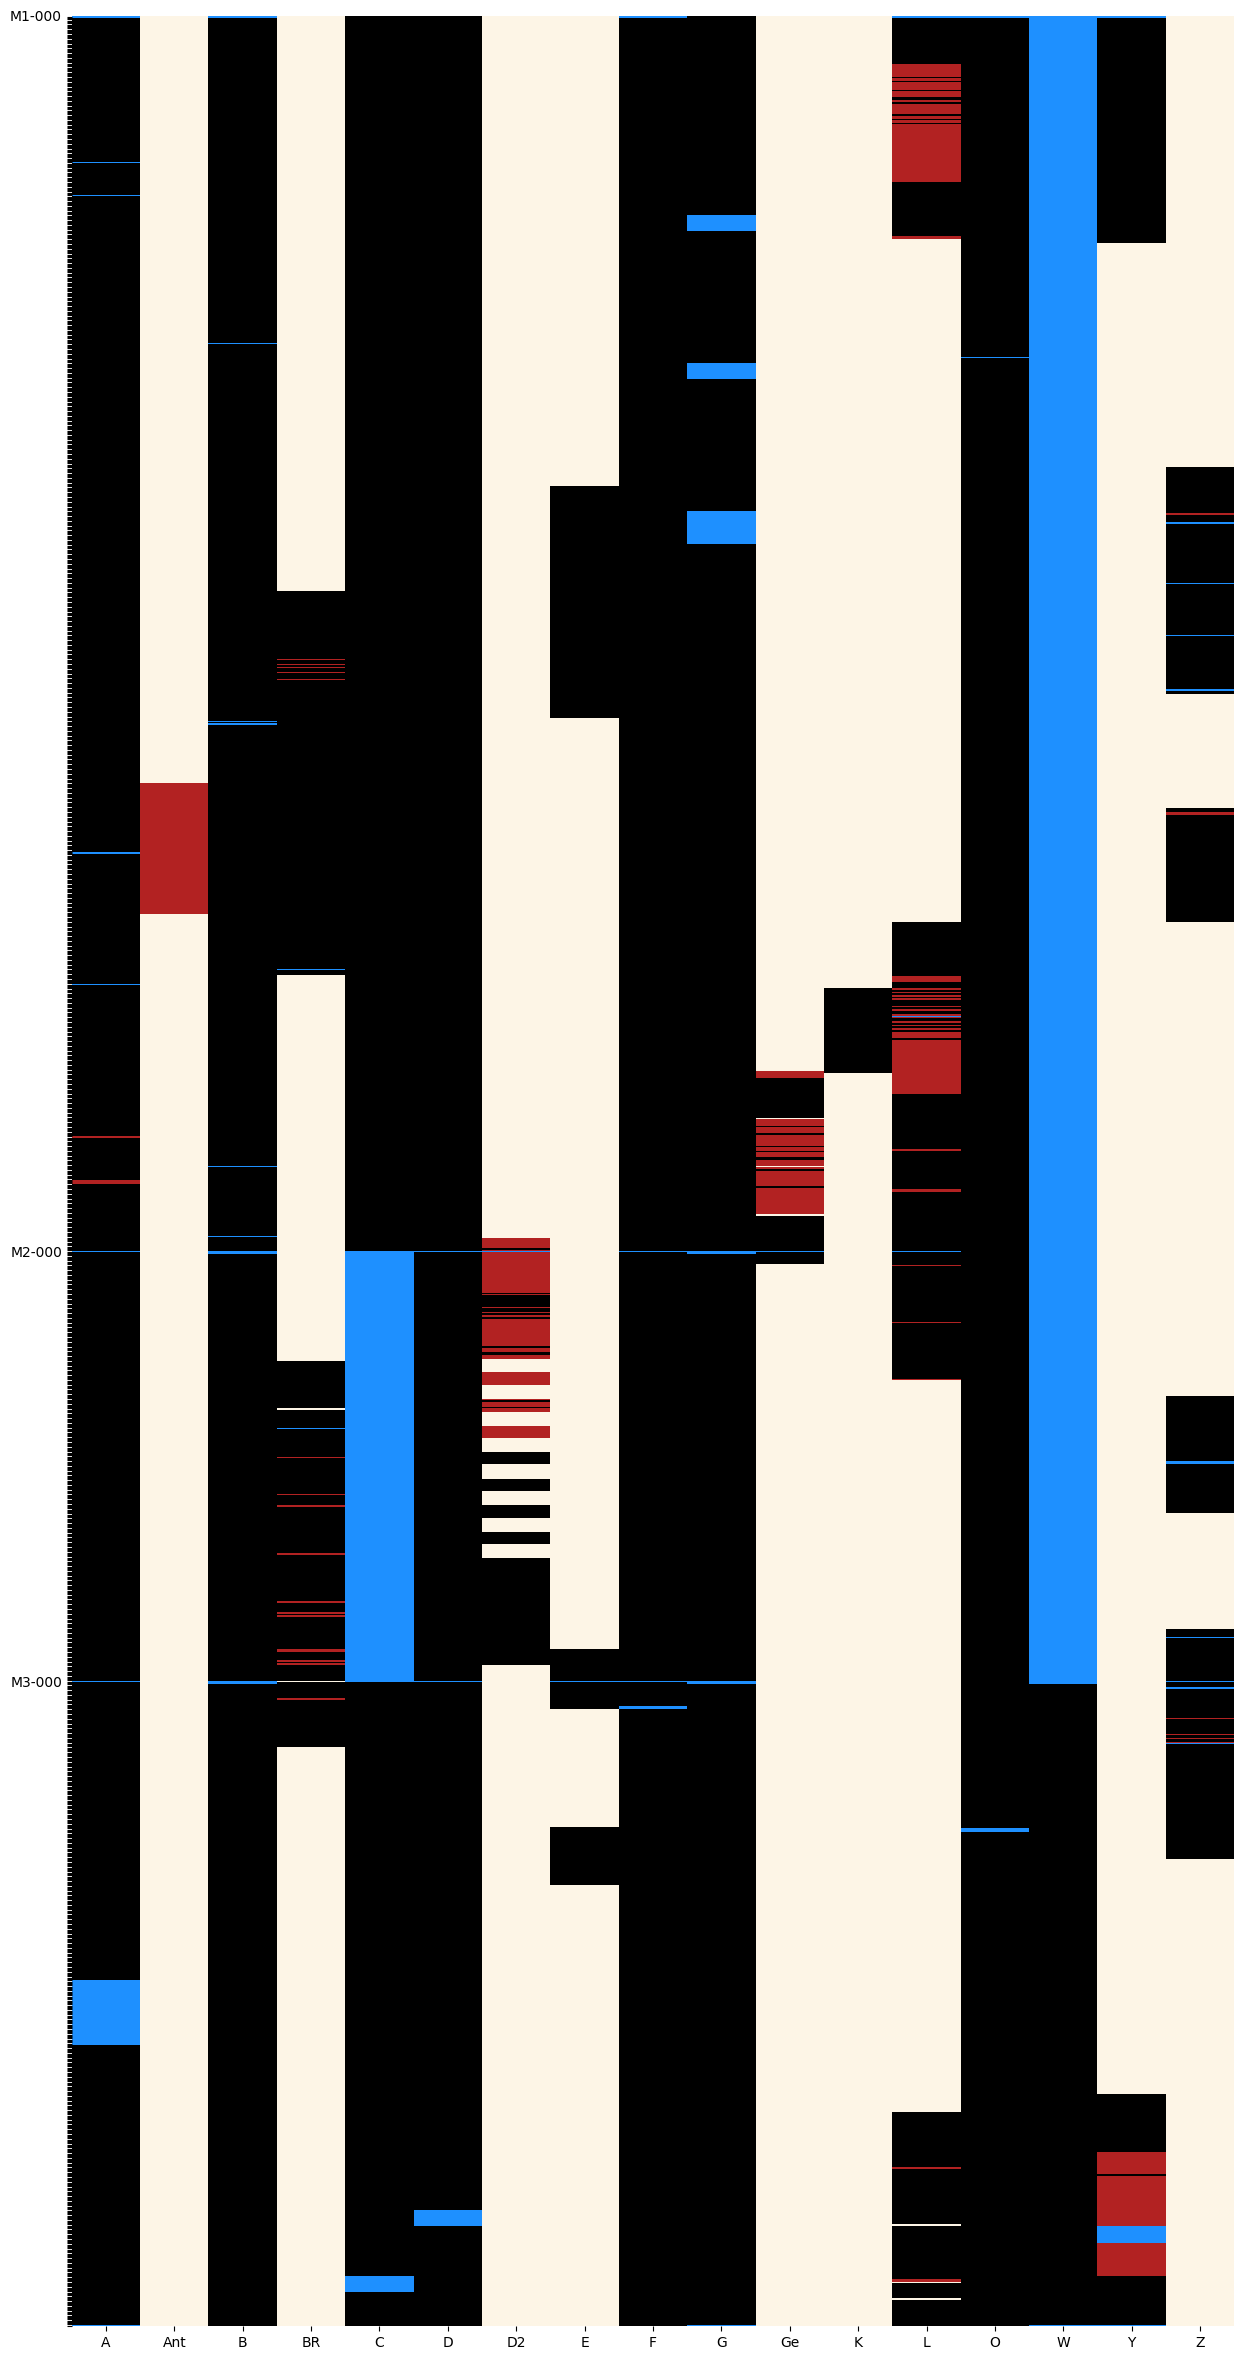

In [475]:
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
num_labels_to_display = 3  # Change this to the desired number
        
cmap = ListedColormap(['black', 'firebrick', 'oldlace', 'dodgerblue'])

custom_ytick_labels = [l if i % (len(all_lines) // num_labels_to_display) == 0 else "" for i, l in enumerate(all_lines)]
fig, ax = plt.subplots(figsize=(15, 30))
        
specific_keys_to_display = ['M1-000', 'M2-000', 'M3-000']
custom_ytick_labels = [l if l in specific_keys_to_display else "" for l in all_lines]
heatmap = sb.heatmap(grid, xticklabels=ms_names, yticklabels=custom_ytick_labels, ax=ax, cbar=False, cmap=cmap)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
        #print(grid.shape)
        #plt.imshow(grid)
plt.savefig('heatmap_newversion.png')

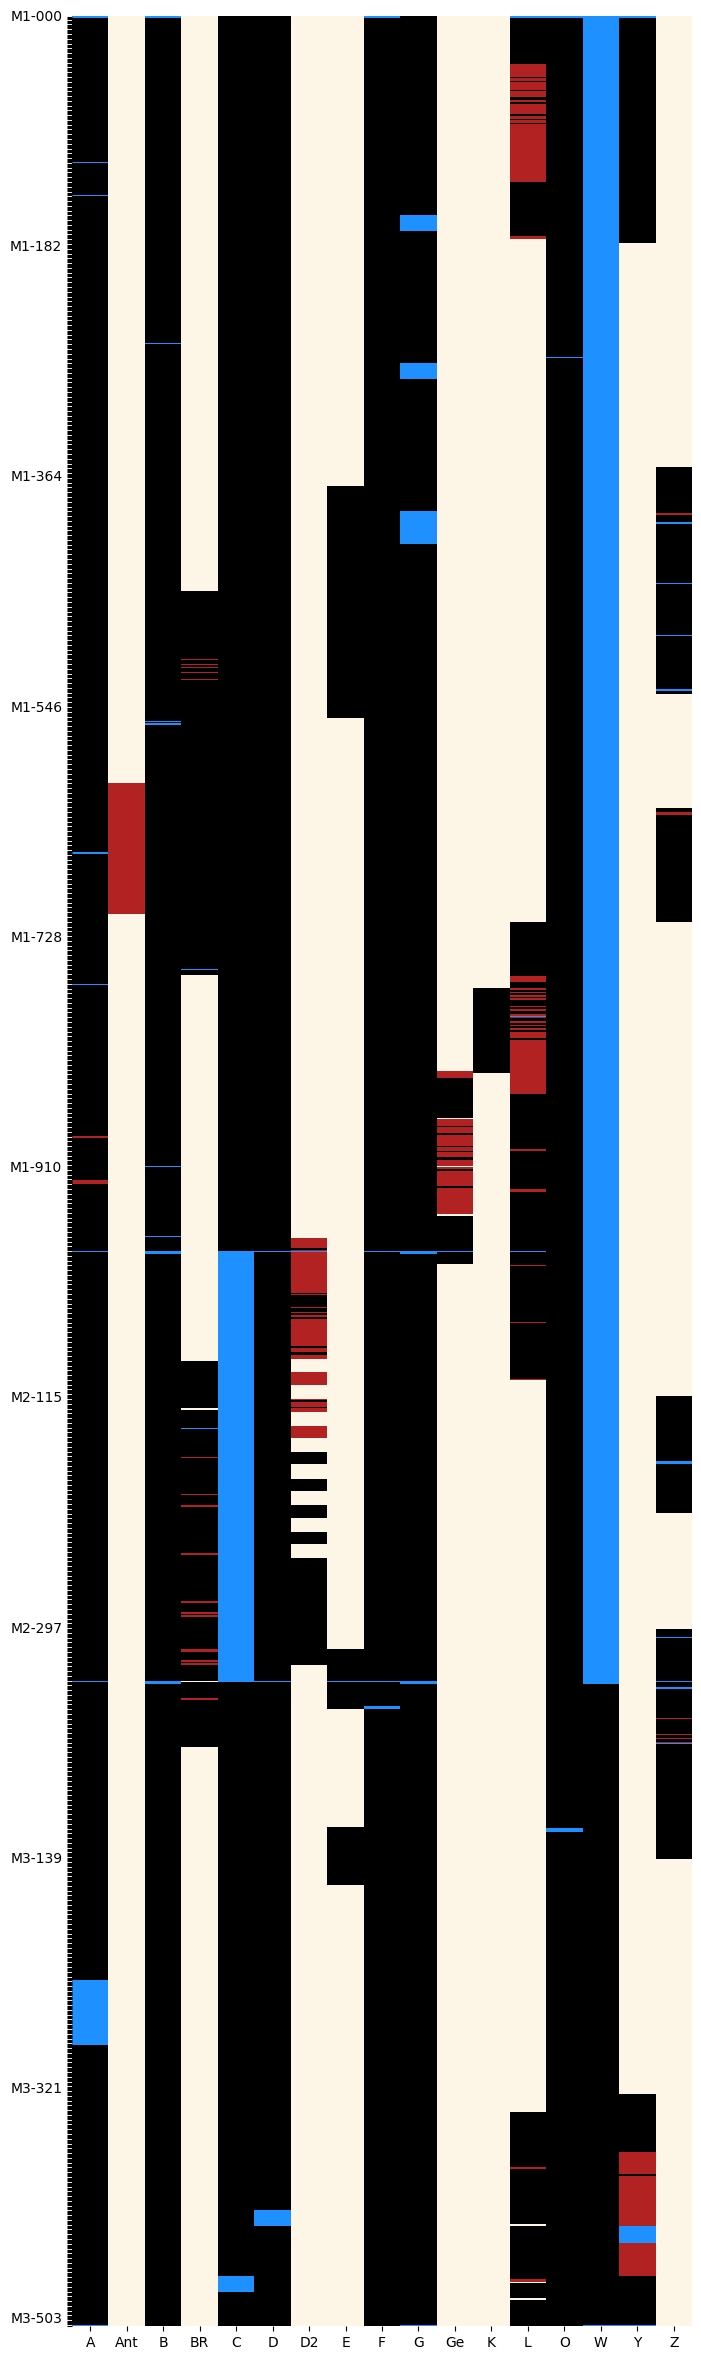

In [459]:
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
num_labels_to_display = 10  # Change this to the desired number

custom_ytick_labels = [l if i % (len(all_lines) // num_labels_to_display) == 0 else "" for i, l in enumerate(all_lines)]
cmap = ListedColormap(['black', 'firebrick', 'oldlace', 'dodgerblue'])

fig, ax = plt.subplots(figsize=(8, 30))

heatmap = sb.heatmap(grid, xticklabels=ms_names, yticklabels=custom_ytick_labels, ax=ax, cbar=False, cmap=cmap)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
#print(grid.shape)
#plt.imshow(grid)

plt.savefig('heatmap_newversion.png')

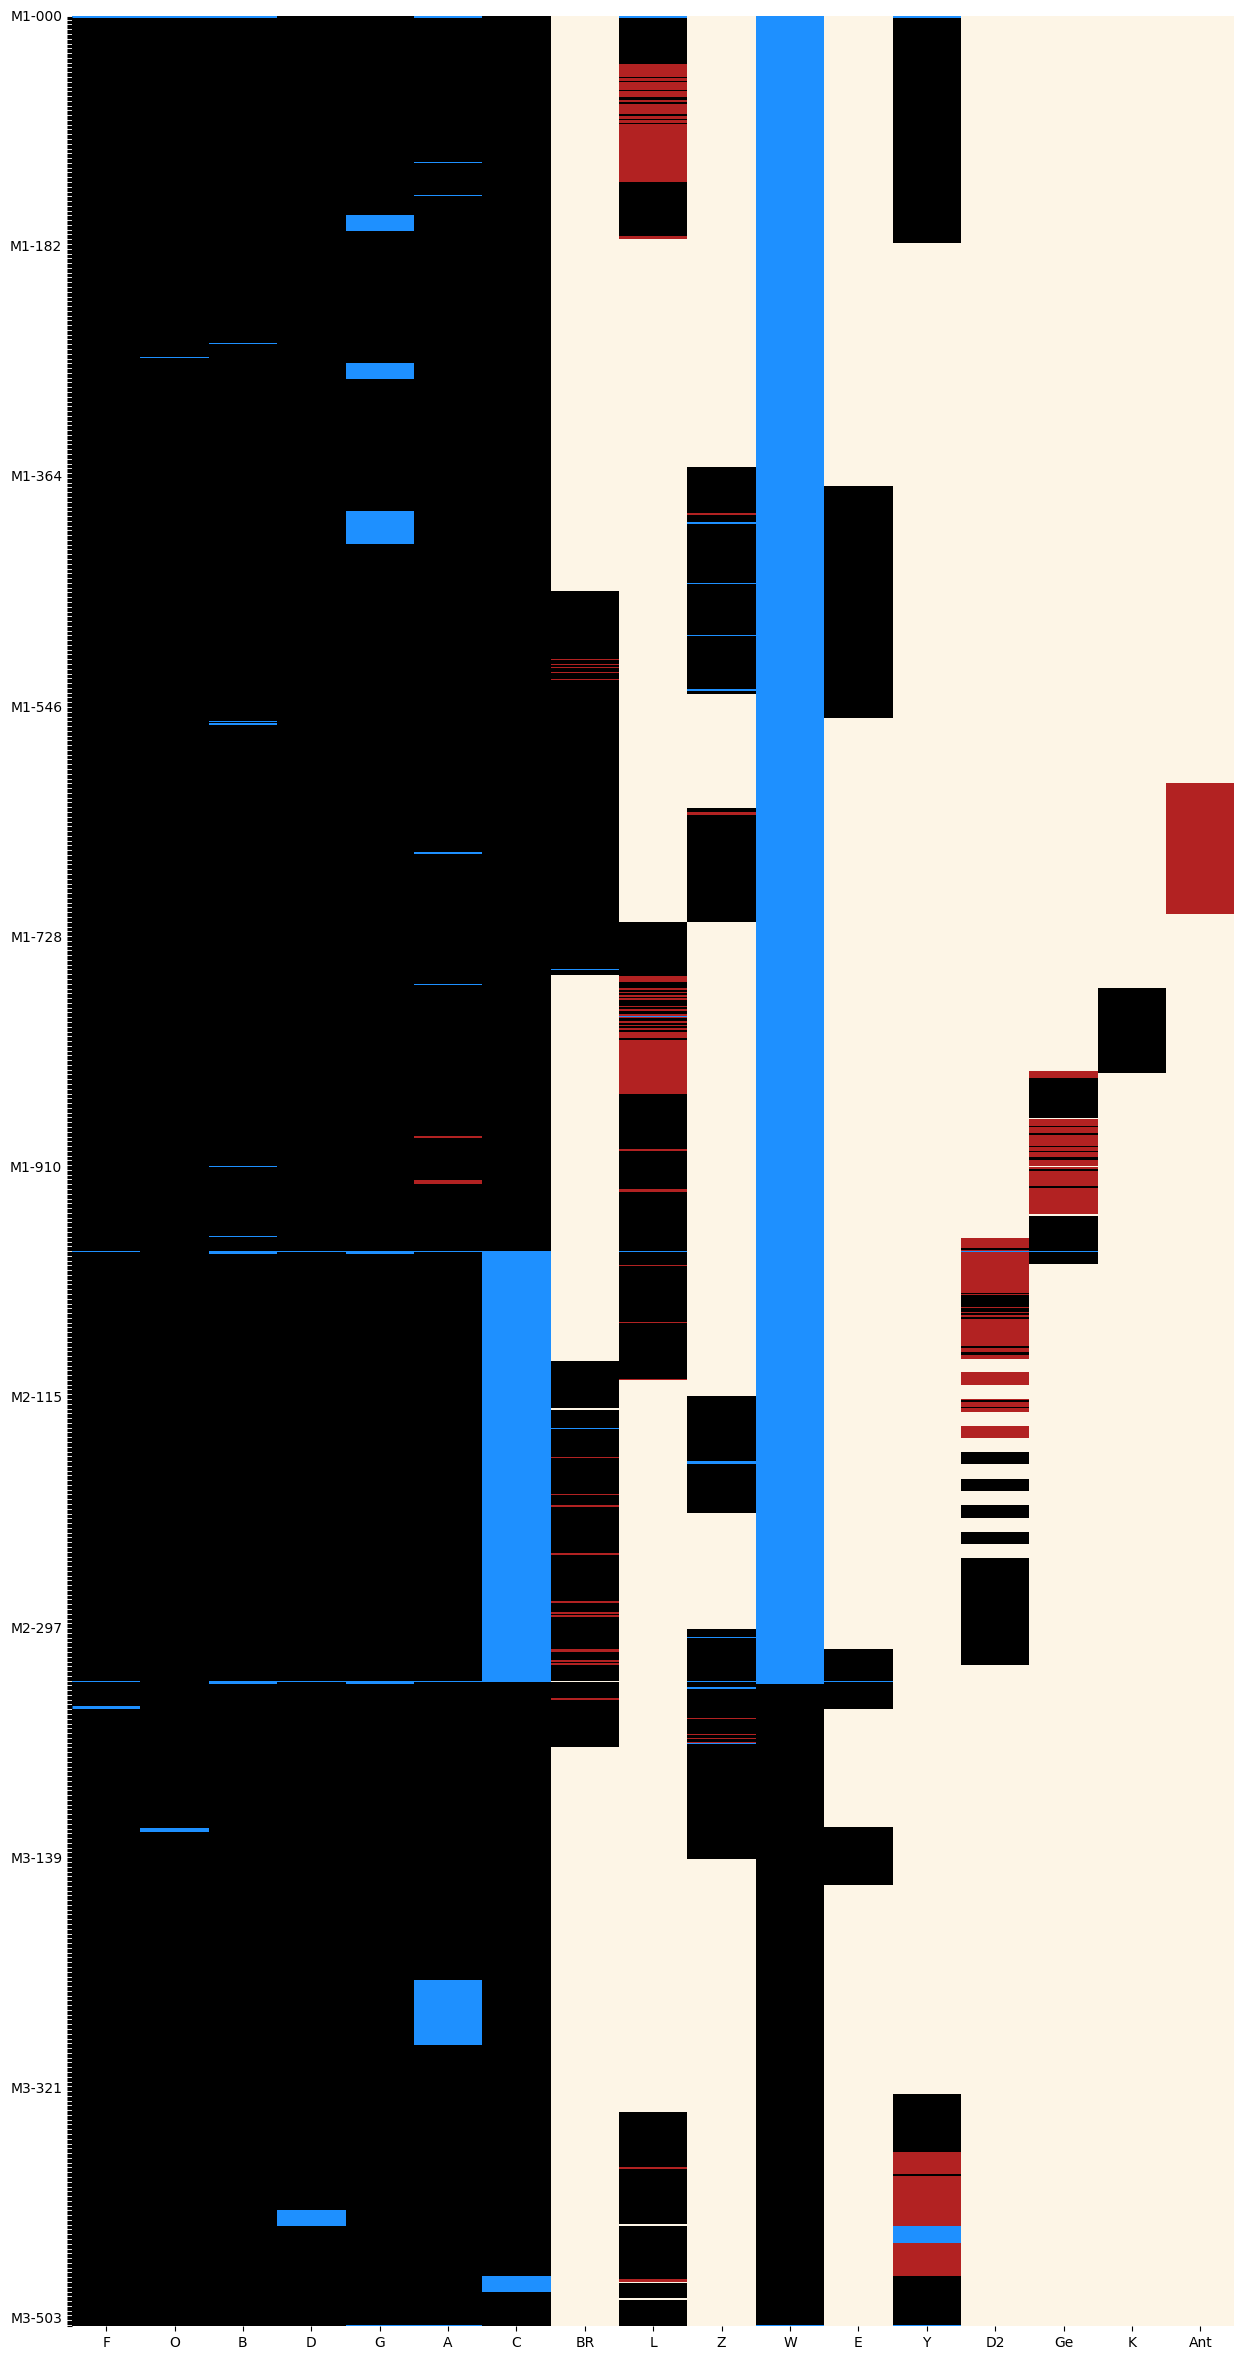

In [462]:
manuscript_line_counts = {}  # Create a dictionary to store manuscript line counts
for ms in mss:
    line_count = sum(1 for line_key in mss[ms] if mss[ms][line_key] not in ['<GAP>', '<NOTE>'])
    manuscript_line_counts[ms] = line_count

# Sort manuscripts by the number of lines (from most lines to fewer lines)
sorted_mss = sorted(manuscript_line_counts.keys(), key=lambda ms: manuscript_line_counts[ms], reverse=True)

# Rest of your code
all_lines = set()

for ms in sorted_mss:
    all_lines.update(mss[ms].keys())

def repl(n):
    parts = n.split('_')
    if len(parts) >= 2:
        n = parts[0] + '-' + parts[-1]
    else:
        n = n
    return n

all_lines = [repl(l) for l in all_lines]
all_lines = sorted(all_lines)
ms_names = sorted_mss  # Use the sorted manuscripts

grid = np.ones((len(all_lines), len(sorted_mss)))

for ms in sorted_mss:
    for line_key in mss[ms]:
        line = mss[ms][line_key]
        if line == '<GAP>':
            grid[all_lines.index(repl(line_key)), sorted_mss.index(ms)] = 0.5
        elif line == '<NOTE>':
            grid[all_lines.index(repl(line_key)), sorted_mss.index(ms)] = 2
        else:
            grid[all_lines.index(repl(line_key)), sorted_mss.index(ms)] = 0

for ms in mss: 
    if ms == 'C':
        specific_ms_index = ms_names.index(ms)  # Get the index of the specific manuscript in ms_names
        start_row = 977  # Replace with your desired starting row
        end_row = 1316
        grid[start_row:end_row + 1, specific_ms_index] = 2
    if ms == 'W':
        specific_ms_index = ms_names.index(ms)  # Get the index of the specific manuscript in ms_names
        start_row = 0  # Replace with your desired starting row
        end_row = 1316
        grid[start_row:end_row + 1, specific_ms_index] = 2

import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
num_labels_to_display = 10  # Change this to the desired number

custom_ytick_labels = [l if i % (len(all_lines) // num_labels_to_display) == 0 else "" for i, l in enumerate(all_lines)]
cmap = ListedColormap(['black', 'firebrick', 'oldlace', 'dodgerblue'])

fig, ax = plt.subplots(figsize=(15, 30))

heatmap = sb.heatmap(grid, xticklabels=ms_names, yticklabels=custom_ytick_labels, ax=ax, cbar=False, cmap=cmap)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
#print(grid.shape)
#plt.imshow(grid)

plt.savefig('heatmap_version_fromlongtoshort.png')